In [1]:
#!pip3 install opencv-python
#!pip3 install scikit-image

import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split

from scipy.ndimage import convolve, binary_fill_holes
from scipy.stats import mode

from skimage import io, exposure
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import rotate, hough_line, hough_line_peaks, resize
from skimage.filters import threshold_otsu, sobel, gaussian, threshold_local

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam


from glob import glob


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, f1_score

2023-07-16 03:25:37.928048: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 03:25:38.003164: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load images from csv file

path = pd.read_csv('Dataset/cards.csv')
path_df = pd.DataFrame(path)
# For column names that contain space, replace the space with an underscore
path_df.columns = [c.replace(' ', '_') for c in path_df.columns]
path_df.head()

,class_index,filepaths,labels,card_type,data_set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train


In [3]:
path_df['suit'] = path_df['labels'].str.split().str[-1]
print(path_df['suit'].unique())

['clubs' 'diamonds' 'hearts' 'spades' 'joker']


In [4]:
# Remove rows with jokers
path_df = path_df[~path_df['suit'].str.contains('joker', case=False)]
card_suits = path_df['suit'].unique()
print(card_suits)

['clubs' 'diamonds' 'hearts' 'spades']


In [5]:
path_df.head()

,class_index,filepaths,labels,card_type,data_set,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,train,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,train,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,train,clubs


In [6]:
path_df = path_df.drop(columns = ['data_set'])
path_df.head()

,class_index,filepaths,labels,card_type,suit
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,clubs
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,clubs
2,0,train/ace of clubs/003.jpg,ace of clubs,ace,clubs
3,0,train/ace of clubs/004.jpg,ace of clubs,ace,clubs
4,0,train/ace of clubs/005.jpg,ace of clubs,ace,clubs


In [7]:
path_df['filepaths'] = path_df['filepaths'].apply(lambda x: 'Dataset/' + x)
path_df.head()

,class_index,filepaths,labels,card_type,suit
0,0,Dataset/train/ace of clubs/001.jpg,ace of clubs,ace,clubs
1,0,Dataset/train/ace of clubs/002.jpg,ace of clubs,ace,clubs
2,0,Dataset/train/ace of clubs/003.jpg,ace of clubs,ace,clubs
3,0,Dataset/train/ace of clubs/004.jpg,ace of clubs,ace,clubs
4,0,Dataset/train/ace of clubs/005.jpg,ace of clubs,ace,clubs


In [8]:
# Split dataframe into train and test sets
train_df, test_df = train_test_split(path_df, test_size=0.2, random_state=42)

# Split train set into train and validation sets
test_df, val_df = train_test_split(train_df, test_size=0.5, random_state=42)

## ResNet

In [9]:
image_size = [224, 224]

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size + [3]))

print(base_model.summary())

2023-07-16 03:25:39.990285: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 03:25:40.024929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 03:25:40.024980: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 03:25:40.040150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:999] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-16 03:25:40.040205: I tensorflow/compile

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [10]:
# Don't want to train model because it is already trained.
for layer in base_model.layers:
    layer.trainable = False

In [11]:
flatten_layer = Flatten()(base_model.output)
prediction  = Dense(52, activation='softmax')(flatten_layer)
model = Model(inputs=base_model.input, outputs=prediction)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [13]:
train_data_generator = ImageDataGenerator(rescale = 1. /255,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

test_data_generator = ImageDataGenerator(rescale=1. /255)


training_set = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')

val_set = test_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')

test_set = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224,224), 
    batch_size=32, 
    class_mode='categorical')



Found 6423 validated image filenames belonging to 52 classes.
Found 3212 validated image filenames belonging to 52 classes.
Found 3211 validated image filenames belonging to 52 classes.


In [14]:
result = model.fit(training_set, 
                   validation_data=val_set, 
                   epochs=250,
                   steps_per_epoch=len(training_set),
                   validation_steps=len(val_set))

Epoch 1/100


2023-07-16 03:25:52.215265: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-07-16 03:25:54.221444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-16 03:25:54.648202: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-16 03:25:55.156378: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56398c9dc390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-16 03:25:55.156410: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-07-16 03:25:55.17515

  1/201 [..............................] - ETA: 10:21 - loss: 4.4082 - accuracy: 0.0312

2023-07-16 03:25:55.366417: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/201 [==============================] - ETA: 0s - loss: 7.6499 - accuracy: 0.1583

2023-07-16 03:26:26.312527: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


201/201 [==============================] - 37s 167ms/step - loss: 7.6499 - accuracy: 0.1583 - val_loss: 4.8489 - val_accuracy: 0.2547
Epoch 2/100
201/201 [==============================] - 33s 163ms/step - loss: 4.9938 - accuracy: 0.2737 - val_loss: 4.6080 - val_accuracy: 0.3257
Epoch 3/100
201/201 [==============================] - 32s 159ms/step - loss: 5.0832 - accuracy: 0.3095 - val_loss: 4.1022 - val_accuracy: 0.3748
Epoch 4/100
201/201 [==============================] - 33s 162ms/step - loss: 4.6276 - accuracy: 0.3570 - val_loss: 5.2549 - val_accuracy: 0.3506
Epoch 5/100
201/201 [==============================] - 33s 162ms/step - loss: 4.6169 - accuracy: 0.3733 - val_loss: 4.6109 - val_accuracy: 0.4131
Epoch 6/100
201/201 [==============================] - 32s 160ms/step - loss: 4.3311 - accuracy: 0.4029 - val_loss: 3.4049 - val_accuracy: 0.4664
Epoch 7/100
201/201 [==============================] - 33s 164ms/step - loss: 4.4948 - accuracy: 0.4115 - val_loss: 3.6815 - val_accurac

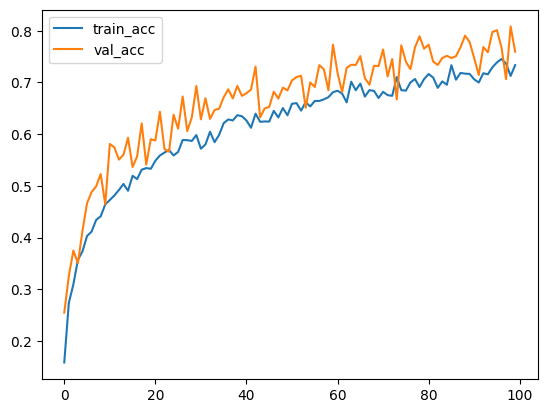

In [15]:
#Plot accuracy
plt.plot(result.history['accuracy'], label='train_acc')
plt.plot(result.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

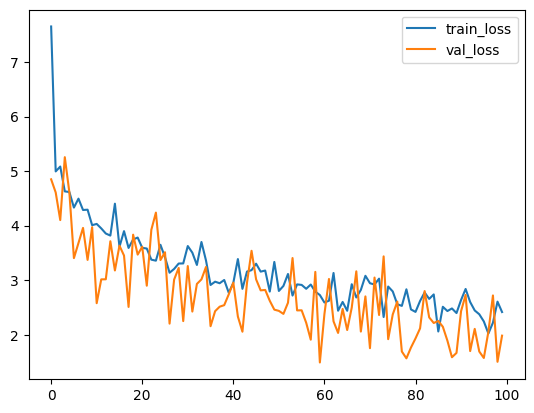

In [16]:
#Plot Loss
plt.plot(result.history['loss'], label='train_loss')
plt.plot(result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
# Evaluate the model on the test set
evaluation = model.evaluate(test_set, steps=len(test_set))

# Print the evaluation metrics
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])


  7/101 [=>............................] - ETA: 1s - loss: 1.7959 - accuracy: 0.7902

2023-07-16 04:20:31.968912: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 2s 20ms/step - loss: 1.7971 - accuracy: 0.7814
Loss: 1.7970778942108154
Accuracy: 0.7813765406608582


In [18]:
# Perform predictions on the test set
predictions = model.predict(test_set, steps=len(test_set))

# Convert the predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Print the predicted labels
print(predicted_labels)


2023-07-16 04:20:34.131845: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


101/101 [==============================] - 2s 18ms/step
[31 11 26 ... 37 19 12]


In [19]:
# Ground truth labels for the test set
true_labels = test_set.labels

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='macro')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Print the metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.016461430680529635
Recall: 0.019013365359629112
F1 Score: 0.016807159934893536
